In [ ]:
import gzip

# Caricamento del dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                samples.append((block["SRC"], block["TGT"], int(block["VOT"])))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"Campioni totali: {len(samples)}")


Campioni totali: 198275


In [2]:
from sklearn.preprocessing import LabelEncoder
import torch

# Codifica utenti come ID numerici
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))




## Link score prediction ##

In [3]:
# Costruisci dataset
X = []
y = []
for src, tgt, vot in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

In [ ]:
from sklearn.model_selection import train_test_split

# Suddivisione in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import torch.nn as nn

# Modello di rete neurale per la predizione del voto
class VotePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 3)  # 3 classi: -1, 0, +1 → shiftate a 0,1,2
        )

    # Predizione
    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [6]:
import torch
print("CUDA disponibile:", torch.cuda.is_available())
print("Dispositivo:", torch.cuda.get_device_name(0))
print("Memoria allocata:", torch.cuda.memory_allocated(0) / 1024**2, "MB")


CUDA disponibile: True
Dispositivo: NVIDIA GeForce RTX 4070
Memoria allocata: 0.0 MB


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import cross_entropy

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

model = VotePredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1, 100): 
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = model(xb)
        class_weights = torch.tensor([1.5, 1.0, 0.8]).to("cuda")  # penalizza di più gli Oppose
        loss = cross_entropy(out, yb + 1, weight=class_weights) # shift labels da [-1,0,1] a [0,1,2]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 504.8067
Epoch 2, Loss: 426.8005
Epoch 3, Loss: 380.0171
Epoch 4, Loss: 355.1140
Epoch 5, Loss: 339.5884
Epoch 6, Loss: 329.1360
Epoch 7, Loss: 319.5109
Epoch 8, Loss: 312.1521
Epoch 9, Loss: 306.6296
Epoch 10, Loss: 299.9502
Epoch 11, Loss: 294.9744
Epoch 12, Loss: 290.4408
Epoch 13, Loss: 285.8942
Epoch 14, Loss: 282.0935
Epoch 15, Loss: 277.6734
Epoch 16, Loss: 273.6835
Epoch 17, Loss: 270.9282
Epoch 18, Loss: 266.9403
Epoch 19, Loss: 263.6821
Epoch 20, Loss: 260.0324
Epoch 21, Loss: 256.0734
Epoch 22, Loss: 253.1688
Epoch 23, Loss: 250.1634
Epoch 24, Loss: 247.1890
Epoch 25, Loss: 243.7951
Epoch 26, Loss: 241.5457
Epoch 27, Loss: 239.0130
Epoch 28, Loss: 236.1961
Epoch 29, Loss: 233.4259
Epoch 30, Loss: 229.9453
Epoch 31, Loss: 227.1537
Epoch 32, Loss: 225.6767
Epoch 33, Loss: 222.2004
Epoch 34, Loss: 220.4336
Epoch 35, Loss: 217.9733
Epoch 36, Loss: 215.9828
Epoch 37, Loss: 212.7033
Epoch 38, Loss: 211.0215
Epoch 39, Loss: 208.4720
Epoch 40, Loss: 205.1599
Epoch 41,

              precision    recall  f1-score   support

      Oppose       0.56      0.65      0.60      8237
     Neutral       0.35      0.16      0.22      2633
     Support       0.87      0.87      0.87     28785

    accuracy                           0.78     39655
   macro avg       0.59      0.56      0.56     39655
weighted avg       0.77      0.78      0.77     39655



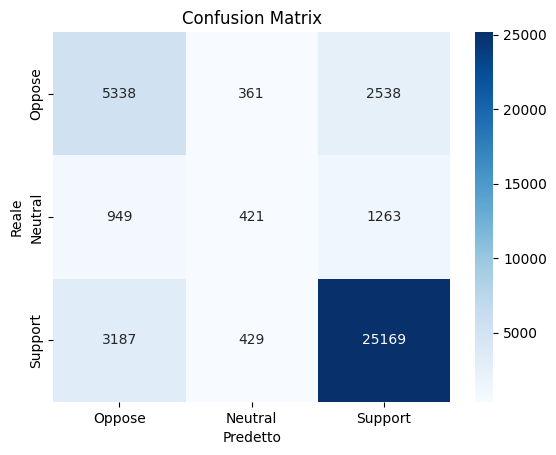

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predizioni
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = (y_test + 1).numpy()  # shift da [-1,0,1] a [0,1,2]

# Report
print(classification_report(y_true, y_pred, target_names=["Oppose", "Neutral", "Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose", "Neutral", "Support"],
            yticklabels=["Oppose", "Neutral", "Support"])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Confusion Matrix")
plt.show()


### **Idee** ###

- Usa il testo solo quando manca il voto: Training: usa SRC, TGT, TXT → predici VOT
- Usa il testo come supporto, non come risposta: Escludi voti con testo esplicito, alleni il modello su voti ambigui
- Fai un modello ibrido: Predice il voto solo da SRC, TGT. Se disponibile, usa TXT per migliorare la predizione

## Link prediction ##

In [9]:
import torch.nn as nn

# Costruzione dataset per link prediction
positive_edges = set((s[0], s[1]) for s in samples)

import random
users = list(user_map.keys())
negative_edges = set()
while len(negative_edges) < len(positive_edges):
    u1, u2 = random.sample(users, 2)
    if (u1, u2) not in positive_edges:
        negative_edges.add((u1, u2))

X_lp = []
y_lp = []

for src, tgt in positive_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(1)

for src, tgt in negative_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(0)

X_lp = torch.tensor(X_lp, dtype=torch.long)
y_lp = torch.tensor(y_lp, dtype=torch.float)

# Split
from sklearn.model_selection import train_test_split
X_lp_train, X_lp_test, y_lp_train, y_lp_test = train_test_split(X_lp, y_lp, test_size=0.2, random_state=42)

# Modello
class LinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()

# Training
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import binary_cross_entropy

train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)

lp_model = LinkPredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

for epoch in range(1, 21):
    lp_model.train()
    total_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[LP] Epoch {epoch}, Loss: {total_loss:.4f}")


[LP] Epoch 1, Loss: 578.5963
[LP] Epoch 2, Loss: 306.4361
[LP] Epoch 3, Loss: 245.1680
[LP] Epoch 4, Loss: 218.9460
[LP] Epoch 5, Loss: 202.6473
[LP] Epoch 6, Loss: 190.1246
[LP] Epoch 7, Loss: 179.3539
[LP] Epoch 8, Loss: 169.3808
[LP] Epoch 9, Loss: 159.3950
[LP] Epoch 10, Loss: 149.1745
[LP] Epoch 11, Loss: 139.1260
[LP] Epoch 12, Loss: 128.4637
[LP] Epoch 13, Loss: 117.3804
[LP] Epoch 14, Loss: 106.5115
[LP] Epoch 15, Loss: 95.4751
[LP] Epoch 16, Loss: 84.8152
[LP] Epoch 17, Loss: 73.9206
[LP] Epoch 18, Loss: 64.2840
[LP] Epoch 19, Loss: 54.9753
[LP] Epoch 20, Loss: 46.6911


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Valutazione Link Prediction
lp_model.eval()
with torch.no_grad():
    y_lp_pred = lp_model(X_lp_test.to("cuda")).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

print(classification_report(y_lp_true, y_lp_bin))
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90     37846
         1.0       0.89      0.90      0.90     37756

    accuracy                           0.90     75602
   macro avg       0.90      0.90      0.90     75602
weighted avg       0.90      0.90      0.90     75602

ROC-AUC: 0.9551949319571724


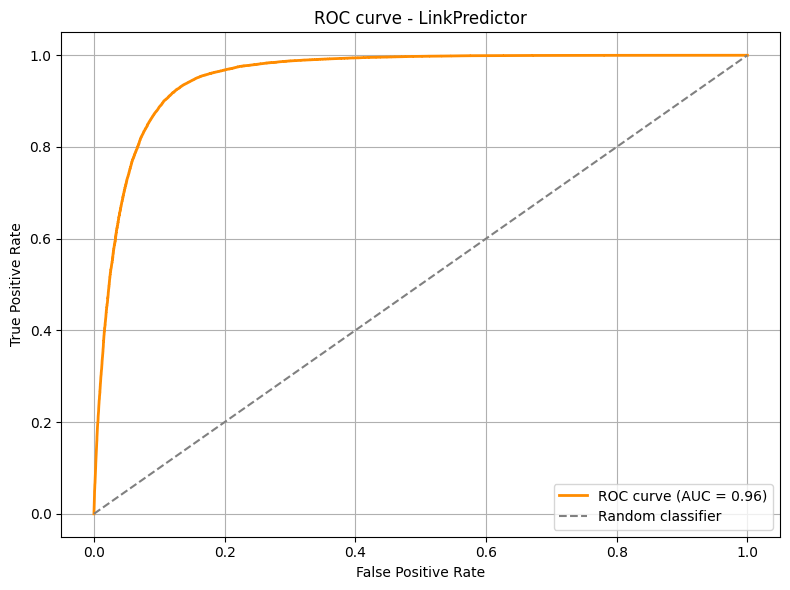

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcola i punti ROC
fpr, tpr, thresholds = roc_curve(y_lp_true, y_lp_pred)
auc = roc_auc_score(y_lp_true, y_lp_pred)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})", color="darkorange", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve - LinkPredictor")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## Clustering ##

In [12]:
# Estrai gli embedding utente
emb_matrix = lp_model.emb.weight.data.cpu().numpy()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(emb_matrix)


In [ ]:
from sklearn.cluster import KMeans

# Clustering KMeans
n_clusters = 2 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(emb_matrix)


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

cmap = cm.get_cmap("tab10", kmeans.n_clusters)
norm = colors.Normalize(vmin=0, vmax=kmeans.n_clusters - 1)

plt.figure(figsize=(10, 8))
sc = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=cluster_labels, cmap=cmap, norm=norm, alpha=0.7)
plt.colorbar(sc, ticks=range(kmeans.n_clusters), label="Cluster")
plt.title("t-SNE degli embedding utente con clustering K=2")
plt.xlabel("Dimensione 1")
plt.ylabel("Dimensione 2")
plt.grid(True)
plt.show()


In [15]:
from collections import defaultdict, Counter

# Conta voti dati e ricevuti per ogni utente
votes_given = defaultdict(int)
votes_received = defaultdict(int)
for src, tgt, vot in samples:
    votes_given[src] += 1
    votes_received[tgt] += 1

# Mappa cluster → utenti
cluster_map = defaultdict(list)
for i, user in enumerate(encoder.classes_):
    cluster_map[cluster_labels[i]].append(user)

# Analizza ogni cluster
for k in range(kmeans.n_clusters):
    users = cluster_map[k]
    given = [votes_given[u] for u in users]
    received = [votes_received[u] for u in users]
    print(f"Cluster {k}:")
    print(f"  Utenti: {len(users)}")
    print(f"  Voti dati (media): {sum(given)/len(users):.2f}")
    print(f"  Voti ricevuti (media): {sum(received)/len(users):.2f}")


Cluster 0:
  Utenti: 3825
  Voti dati (media): 40.71
  Voti ricevuti (media): 51.09
Cluster 1:
  Utenti: 7556
  Voti dati (media): 5.63
  Voti ricevuti (media): 0.38


In [16]:
from collections import defaultdict, Counter

# Conta voti dati e ricevuti per ogni utente, divisi per tipo
votes_given_type = defaultdict(lambda: Counter({-1: 0, 0: 0, 1: 0}))
votes_received_type = defaultdict(lambda: Counter({-1: 0, 0: 0, 1: 0}))

for src, tgt, vot in samples:
    votes_given_type[src][vot] += 1
    votes_received_type[tgt][vot] += 1

# Mappa cluster → utenti
cluster_map = defaultdict(list)
for i, user in enumerate(encoder.classes_):
    cluster_map[cluster_labels[i]].append(user)

# Analizza ogni cluster
for k in range(kmeans.n_clusters):
    users = cluster_map[k]
    n = len(users)

    # Medie assolute
    pos_given = sum(votes_given_type[u][1] for u in users) / n
    neg_given = sum(votes_given_type[u][-1] for u in users) / n
    neut_given = sum(votes_given_type[u][0] for u in users) / n

    pos_received = sum(votes_received_type[u][1] for u in users) / n
    neg_received = sum(votes_received_type[u][-1] for u in users) / n
    neut_received = sum(votes_received_type[u][0] for u in users) / n

    # Percentuali normalizzate (rispetto al totale voti dati/ricevuti per utente)
    norm_pos_given = sum(
        votes_given_type[u][1] / sum(votes_given_type[u].values()) if sum(votes_given_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neg_given = sum(
        votes_given_type[u][-1] / sum(votes_given_type[u].values()) if sum(votes_given_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neut_given = sum(
        votes_given_type[u][0] / sum(votes_given_type[u].values()) if sum(votes_given_type[u].values()) > 0 else 0
        for u in users
    ) / n

    norm_pos_received = sum(
        votes_received_type[u][1] / sum(votes_received_type[u].values()) if sum(votes_received_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neg_received = sum(
        votes_received_type[u][-1] / sum(votes_received_type[u].values()) if sum(votes_received_type[u].values()) > 0 else 0
        for u in users
    ) / n
    norm_neut_received = sum(
        votes_received_type[u][0] / sum(votes_received_type[u].values()) if sum(votes_received_type[u].values()) > 0 else 0
        for u in users
    ) / n

    print(f"Cluster {k}:")
    print(f"  Utenti: {n}")
    print(f"  Voti dati (media): {pos_given + neg_given + neut_given:.2f}")
    print(f"    Positivi: {pos_given:.2f} ({norm_pos_given:.2%})")
    print(f"    Negativi: {neg_given:.2f} ({norm_neg_given:.2%})")
    print(f"    Neutri:   {neut_given:.2f} ({norm_neut_given:.2%})")
    print(f"  Voti ricevuti (media): {pos_received + neg_received + neut_received:.2f}")
    print(f"    Positivi: {pos_received:.2f} ({norm_pos_received:.2%})")
    print(f"    Negativi: {neg_received:.2f} ({norm_neg_received:.2%})")
    print(f"    Neutri:   {neut_received:.2f} ({norm_neut_received:.2%})")
    print()

    total_pos_given = sum(votes_given_type[u][1] for u in users)
    total_neg_given = sum(votes_given_type[u][-1] for u in users)
    total_neut_given = sum(votes_given_type[u][0] for u in users)
    total_given = total_pos_given + total_neg_given + total_neut_given

    print(f"  Voti dati totali: {total_given}")
    print(f"    Positivi: {total_pos_given} ({total_pos_given / total_given:.2%})")
    


Cluster 0:
  Utenti: 3825
  Voti dati (media): 40.71
    Positivi: 29.87 (61.34%)
    Negativi: 8.13 (15.66%)
    Neutri:   2.70 (4.49%)
  Voti ricevuti (media): 51.09
    Positivi: 37.55 (52.39%)
    Negativi: 10.31 (24.59%)
    Neutri:   3.24 (5.84%)

  Voti dati totali: 155704
    Positivi: 114256 (73.38%)
Cluster 1:
  Utenti: 7556
  Voti dati (media): 5.63
    Positivi: 4.00 (72.28%)
    Negativi: 1.33 (20.51%)
    Neutri:   0.31 (3.83%)
  Voti ricevuti (media): 0.38
    Positivi: 0.11 (0.89%)
    Negativi: 0.23 (3.12%)
    Neutri:   0.04 (0.34%)

  Voti dati totali: 42571
    Positivi: 30195 (70.93%)


### Grafo associato usando il k-means ###

In [ ]:
import networkx as nx

# Grafo diretto con pesi
G = nx.DiGraph()
for src, tgt, vot in samples:
    G.add_edge(src, tgt, weight=vot)


In [18]:
user_to_cluster = dict(zip(encoder.classes_, cluster_labels))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Colormap con K colori
cmap = cm.get_cmap("tab10", kmeans.n_clusters)
node_colors = [cmap(user_to_cluster.get(node, 0)) for node in G.nodes()]


C:\Users\lucal\AppData\Local\Temp\ipykernel_19928\1188519825.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10", kmeans.n_clusters)


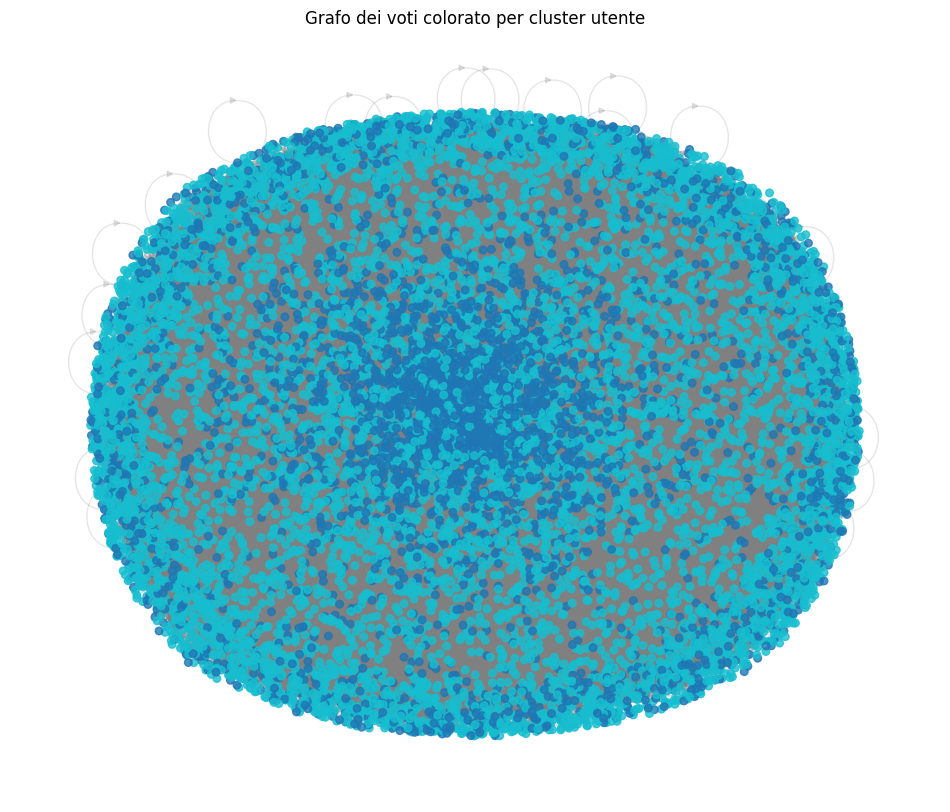

In [20]:
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42, k=0.15) 
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.2)
plt.title("Grafo dei voti colorato per cluster utente")
plt.axis("off")
plt.show()
